## Introduction

We will create a super resolution model from scratch to enhance the image quality

## Setting up Environment

### Upgrade Libraries

In [ ]:
!pip install opencv-contrib-python --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72


In [ ]:
import cv2
cv2.__version__

'4.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Mount Gdrive and download datasets

* Download kaggle json to download dataset
* Upload the new dataset to drive
* Copy the Authentication json for kaggle to download our datasets, 1 time activity

In [ ]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''

!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#-d flag is used to specify the dataset name
#-p flag specifies the directory where the dataset should be saved.
#%%timezip
import os
os.environ['KAGGLE_USERNAME'] = "aubaialkhabbaz"
os.environ['KAGGLE_KEY'] = "2715ab36f8842a62a77fc816d7f14851"
#!kaggle datasets download -d scribbless/another-anime-face-dataset -p dataset
!kaggle datasets download -d ryandpark/fruit-quality-classification -p dataset
!unzip -q dataset/fruit-quality-classification.zip -d dataset/fruit-quality-classification
!rm dataset/fruit-quality-classification.

# !cp /content/drive/MyDrive/datasets/dataset.zip .
# !unzip -q dataset.zip

100% 3.02G/3.03G [00:35<00:00, 78.9MB/s]
100% 3.03G/3.03G [00:35<00:00, 91.0MB/s]
rm: cannot remove 'dataset/fruit-quality-classification.': No such file or directory


In [ ]:
import os
dir_dataset =  '/content/drive/MyDrive/MRI_SR/dataset/train'
files_img = [os.path.join(dir_dataset, x) for x in os.listdir(dir_dataset)]

In [ ]:
len(files_img), files_img[0: 92219]

(1149,
 ['/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190809_164144.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190809_120212.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190809_122206.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190809_120940.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/IMG_9602.JPG',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190809_121441.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/20190812_183443.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/IMG_9514.JPG',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/IMG20200728181041.jpg',
  '/content/dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good/2019080

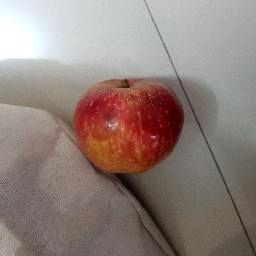

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(files_img[201], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Downsample images

> Here we are going to write some downsampling code through which we are going to generate some low resolution images

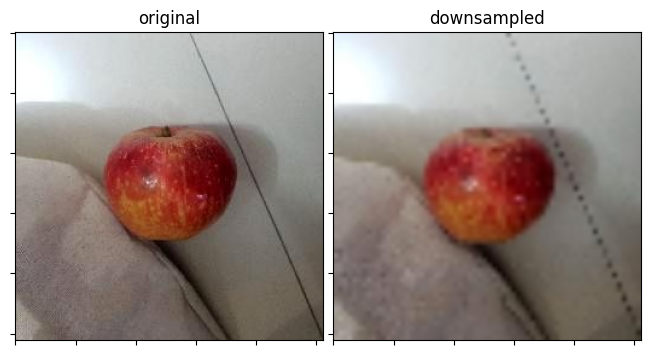

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=axes_pad)

    i = 0
    for ax, img in zip(grid, images):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.minorticks_off()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        i += 1
    plt.show()

def downsample(img_file, scale=0.3):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    img_small = cv2.resize(img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
    return img, img_small

_, img_small = downsample(files_img[201], scale=0.25)

# Lets resize the image for plotting purposes
img_small_resize = cv2.resize(img_small, (img.shape[0], img.shape[1]))

titles = ["original", "downsampled"]
images = [img, img_small_resize]
plot_images(images, titles, figsize=(10., 4.), cols=len(images))

### Lets downsample all images for training

In [ ]:
dir_dataset_lr =  'dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good_lr'

if not os.path.exists(dir_dataset_lr):
    os.makedirs(dir_dataset_lr)

for file_img in files_img:
    img, img_small = downsample(file_img, scale=0.25)
    file_img_lr = os.path.join(dir_dataset_lr, os.path.basename(file_img))
    cv2.imwrite(file_img_lr, img_small)

In [ ]:
dir_dataset_lr =  'dataset/fruit-quality-classification/Good Quality_Fruits/Apple_Good_lr'
files_img_lr = [os.path.join(dir_dataset_lr, x) for x in os.listdir(dir_dataset_lr)]
print("HR images: {}, LR images: {}".format(len(files_img), len(files_img_lr)))

HR images: 1149, LR images: 1149


## Super Resolution - Model Creation

### SR GAN

In [ ]:
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add, BatchNormalization, Activation, LeakyReLU, Layer
from tensorflow.keras.models import Model

In [ ]:
class SubpixelConv2D(Layer):

    def __init__(self, upsampling_factor=2, **kwargs): #  refers to the instance of the class that is being operated on.
        super(SubpixelConv2D, self).__init__(**kwargs) #init the parent class and allows you to call methods of a parent class.
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space(inputs, self.upsampling_factor) # convert input from (h, w, c) to (h*r, w*r, c/(r*r)),

    def get_config(self):   # returns a dictionary that contains the configuration of the layer
        config = {'upsampling_factor': self.upsampling_factor}
        base_config = super(SubpixelConv2D, self).get_config()  #super() is a built-in function that allows you to call a method in a parent class(Layer).
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor

        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor

        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor

        dims = [ input_shape[0],   #batch size
                 input_shape_1,  # h
                 input_shape_2,  # w
                 int(input_shape[3]/factor)  #channel/factor
               ]
        return tuple( dims )

In [ ]:
from tensorflow.keras.layers import Dense

# create a Dense layer with some configuration
dense_layer = Dense(units=64, activation='relu')

# get the configuration of the layer
config = dense_layer.get_config()
print(config)
# recreate the layer from the configuration
new_dense_layer = Dense.from_config(config)
# check that the two layers are equivalent
print(dense_layer.get_config() == new_dense_layer.get_config()) # should print True

{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
True


In [ ]:
config = {'upsampling_factor': 2}
base_config = {'config': 4}
print(dict(list(base_config.items()) + list(config.items())))

{'config': 4, 'upsampling_factor': 2}


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
#from subpixel_conv_2d import SubpixelConv2D # assuming you have already imported this class

input_shape = (4, 4, 16)
upsampling_factor = 2

# create an input tensor
x = Input(shape=input_shape)

# apply a convolutional layer
x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)

# apply the SubpixelConv2D layer
X = SubpixelConv2D(upsampling_factor=upsampling_factor)(x)

# create the model
model = Model(inputs=x, outputs=X)

# print the output shape of the model
print(model.output_shape)

(None, 8, 8, 16)


### Generator

In [ ]:
def generator_model(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)

    g_init = tf.random_normal_initializer(1., 0.02)
    relu = Activation('relu')

    layer_input = Input(shape=input_shape)
    # input shape 64 x 64 for generator
    #conv2d kernal size in  the paper (9,9)
    #activation function in the paper Prelu in the code we using relu
    # kernel_initializer='HeNormal   for initi  weight for conv2d  ( --- read about it ---)
    layer_past_block = Conv2D(64, (3,3), padding='SAME', activation= 'relu', kernel_initializer='HeNormal')(layer_input)
    # layer_initial = layer_past_block to save first layer information for sum at the end of residual blocks
    layer_initial = layer_past_block

    # B residual blocks
    for i in range(16):
        # in the paper they use  16 residual blocks
        layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

        layer = add([layer_past_block, layer])
        layer_past_block = layer

    layer = Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer = add([layer, layer_initial])  # adding initial layer, such that model can skip entire residual blocks
    # B residual blocks end

    #layer = layer_initial # extra

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    layer = Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = SubpixelConv2D(upsampling_factor=2)(layer)
    layer = relu(layer)

    #layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(layer)
    #kernal conv2d final layer kernal size 9x9 in the paper
    layer_final = Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'relu')(layer)

    model = Model(inputs=layer_input, outputs=layer_final, name="generator")
    return model

### Discriminator

In [ ]:
# discriminator
def discriminator_model(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)

    ly_relu= LeakyReLU(alpha= 0.2)

    df_dim = 16

    layer_input = Input(input_shape)

    layer = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer_input)
    layer = ly_relu(layer)

    for i in range(2, 6):
        layer = Conv2D(df_dim*(2**i), (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(layer)
        layer = ly_relu(layer)
        layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer_past = layer

    # Residual Block starts
    layer = Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = ly_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

    layer = Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = BatchNormalization(gamma_initializer= g_init)(layer)

    layer = add([layer, layer_past])
    # Residual Block ends

    layer = Flatten()(layer)
    layer_final = Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(layer)
    model = Model(inputs=layer_input, outputs=layer_final, name="discriminator")

    return model

In [ ]:
for i in range(2, 6):
  print(i)
  print("======")
  print(16*(2**i))

2
64
3
128
4
256
5
512


### VGG model

In [ ]:
def vgg19_model(input_shape):
    vgg = tf.keras.applications.VGG19( include_top=False, weights='imagenet',
                                       input_tensor=None, input_shape=input_shape,
                                       pooling=None, classes=1000,
                                       classifier_activation='softmax' )

    layer_input = Input(shape=input_shape)
    layer = vgg.layers[0](layer_input) #layer zero

    for layer_vgg in vgg.layers[1:17]: #layer 0 to 17
        layer = layer_vgg(layer)

    model = Model(inputs=layer_input, outputs=layer, name='vgg')
    return model

### Hyperparams

In [ ]:
learning_rate = 0.0002

## Adversarial learning (SRGAN)
n_epoch = 10       ## overall training epochs
n_epoch_init = 5  ## initialize generator with Epochs
batch_size = 16    ## batch size for training
steps_per_epoch = 500

# create folders to save result images and trained models
img_save_dir = "samples"
checkpoint_dir = "models"

#### Ensuring directories exist

In [ ]:
if os.path.exists(img_save_dir):
    shutil.rmtree(img_save_dir)

os.makedirs(img_save_dir)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Datasets Iterator

In [ ]:
dataset_lr = tf.keras.utils.image_dataset_from_directory(dir_dataset_lr, labels=None, image_size=(64, 64), batch_size=batch_size, shuffle=False)
dataset_hr = tf.keras.utils.image_dataset_from_directory(dir_dataset, labels=None, image_size=(256, 256), batch_size=batch_size, shuffle=False)
dataset =  tf.data.Dataset.zip((dataset_lr, dataset_hr))

Found 1149 files belonging to 1 classes.
Found 1149 files belonging to 1 classes.


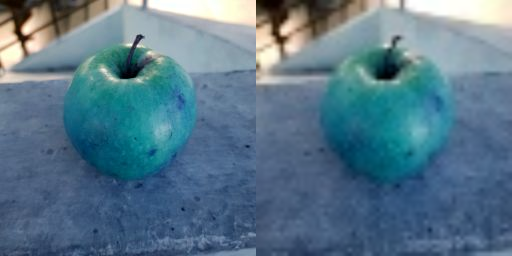

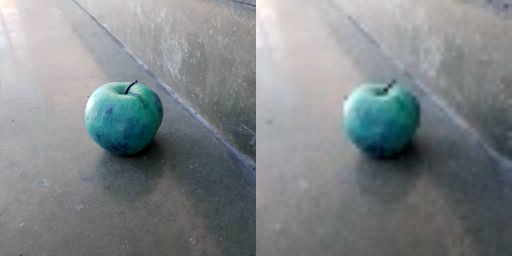

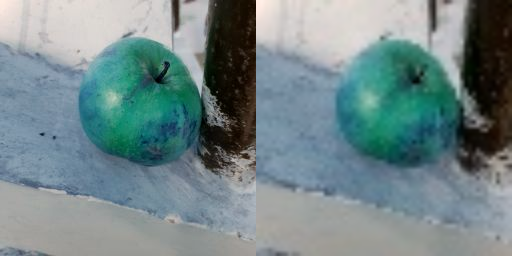

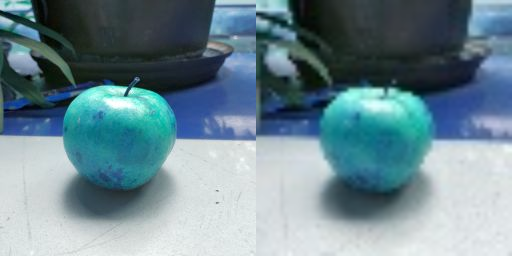

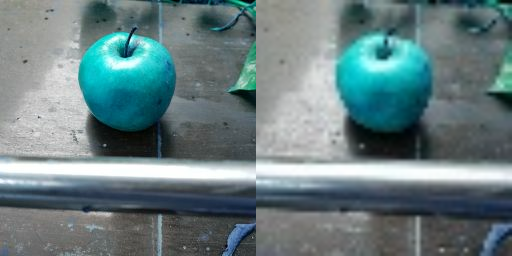

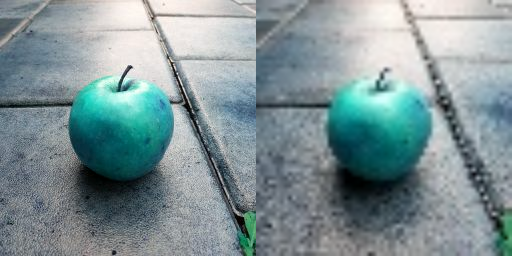

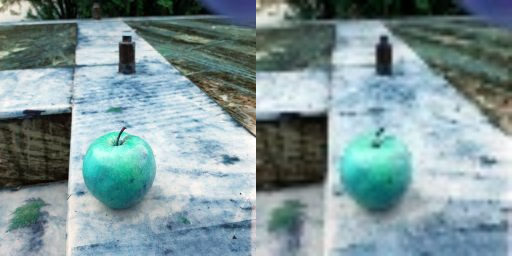

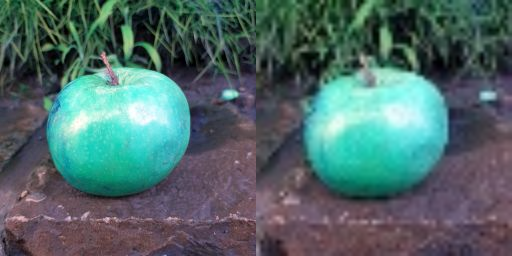

In [ ]:
# # code to verify that img_batch_lr and img_batch_hr are in sync
i = 0
for img_batch_lr, img_batch_hr in dataset:#     print(img_batch_hr.shape, img_batch_lr.shape)

    img_hr = img_batch_hr[0].numpy()
    img_lr = img_batch_lr[0].numpy()

    img_lr_resize = cv2.resize(img_lr, (img_hr.shape[0], img_hr.shape[1]))
    cv2_imshow(np.hstack([img_hr, img_lr_resize]))

    if i > 6:
      break

    i += 1

### Initialization

In [ ]:
model_gen = generator_model((64, 64, 3))
model_dis = discriminator_model((256, 256, 3))
model_vgg = vgg19_model((256, 256, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
g_optimizer_init = tf.optimizers.Adam(learning_rate)
g_optimizer = tf.optimizers.Adam(learning_rate)
d_optimizer = tf.optimizers.Adam(learning_rate)

### Initialize Generator

Lets give generator head start by letting it train alone for some steps

In [ ]:
from PIL import Image

g_optimizer_init = tf.optimizers.Adam(0.0002)

# Lets run generator for initial epochs
for epoch in range(n_epoch_init):
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch:
            break

        with tf.GradientTape() as tape:
            Y_pred = model_gen(X)

            # Our loss function is MSE of pixel differences in actual and generated image
            mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, Y_pred), axis=-1))
            grad = tape.gradient(mse_loss, model_gen.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, model_gen.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step, mse: {:.3f} ".format(epoch, step , mse_loss))

        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            #img = Image.fromarray(np.uint8(img * 255))
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_init.png'.format(epoch)))

Epoch: [0/0] step, mse: 547461201920.000 
1/1 [==============================] - 1s 727ms/step
Epoch: [1/0] step, mse: 74703720.000 
1/1 [==============================] - 0s 246ms/step
Epoch: [2/0] step, mse: 33705192.000 
1/1 [==============================] - 0s 260ms/step


KeyboardInterrupt: ignored

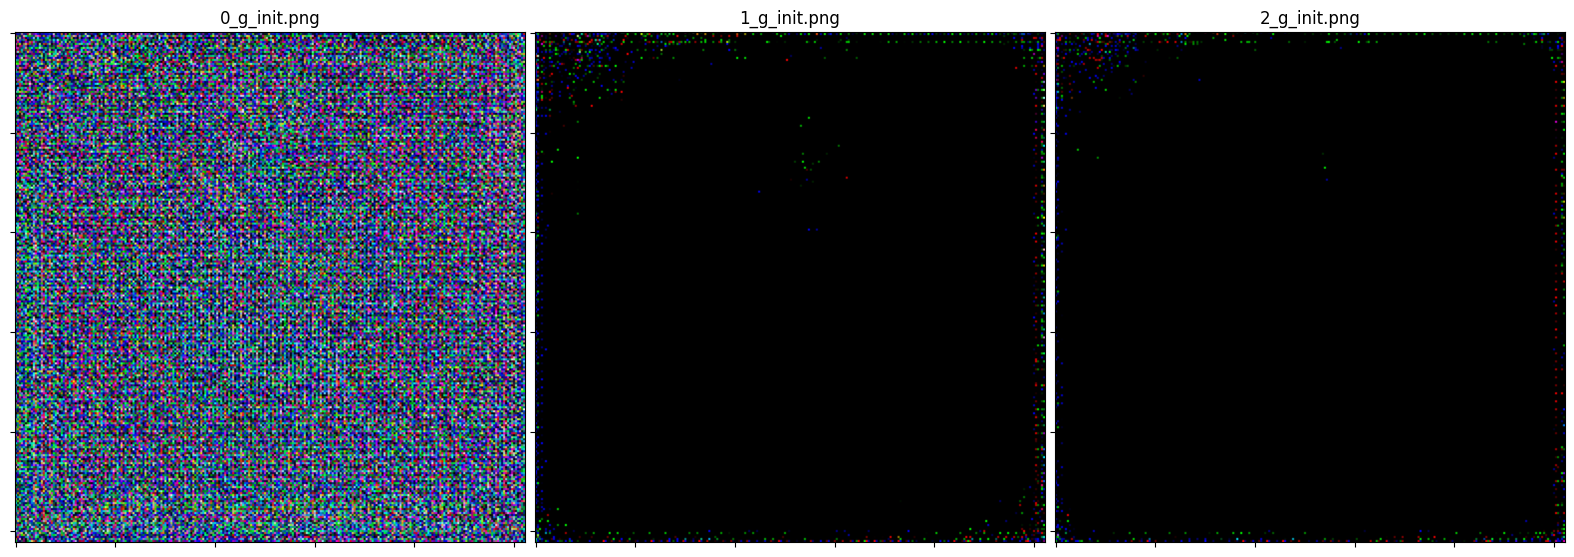

In [ ]:
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x: not 'train' in x, sample_images_filepaths))
sample_images_filepaths.sort(key = lambda x: x.split('_')[0])

images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

plot_images(images, titles, figsize=(20., 8.), rows=1, cols=len(images))

In [ ]:
for epoch in range(n_epoch):
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch:
            break

        with tf.GradientTape(persistent=True) as tape:
            fake_img = model_gen(X)
            fake_logits = model_dis(fake_img)
            real_logits = model_dis(Y)
            fake_feature = model_vgg(fake_img)
            real_feature = model_vgg(Y)

            # Discriminator. loss
            d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
            d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
            d_loss = d_loss1 + d_loss2

            # Generator. loss
            g_gan_loss = 2e-3 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))
            mse_loss   = 2e-1 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss   = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1)) #is used to calculate the mean value of the VGG loss across the batch.
            g_loss = mse_loss + vgg_loss + g_gan_loss

            grad = tape.gradient(g_loss, model_gen.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, model_gen.trainable_weights))

            grad = tape.gradient(d_loss, model_dis.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, model_dis.trainable_weights))

        if step % 100 == 0:
            print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(epoch, step , d_loss, g_loss))

        if step == 0:
            img = model_gen.predict(X[0:1])[0]
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_train.png'.format(epoch)))

Epoch: [0/0] step: D.loss: 1.006: G.loss: 6054940.500
1/1 [==============================] - 0s 263ms/step


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

fake_img = tf.constant([[[1, 6, 3], [4, 5, 6]],
                        [[7, 8, 9], [10, 11, 12]]])

Y = tf.constant([[[2, 3, 4], [5, 6, 7]],
                 [[8, 9, 10], [11, 12, 13]]])
print(Y.shape)
print("====================")
print(tf.math.squared_difference(fake_img, Y))
print("====================")
print(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
mse_loss

(2, 2, 3)
tf.Tensor(
[[[1 9 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]]], shape=(2, 2, 3), dtype=int32)
tf.Tensor(
[[3 1]
 [1 1]], shape=(2, 2), dtype=int32)


<tf.Tensor: shape=(), dtype=int32, numpy=1>

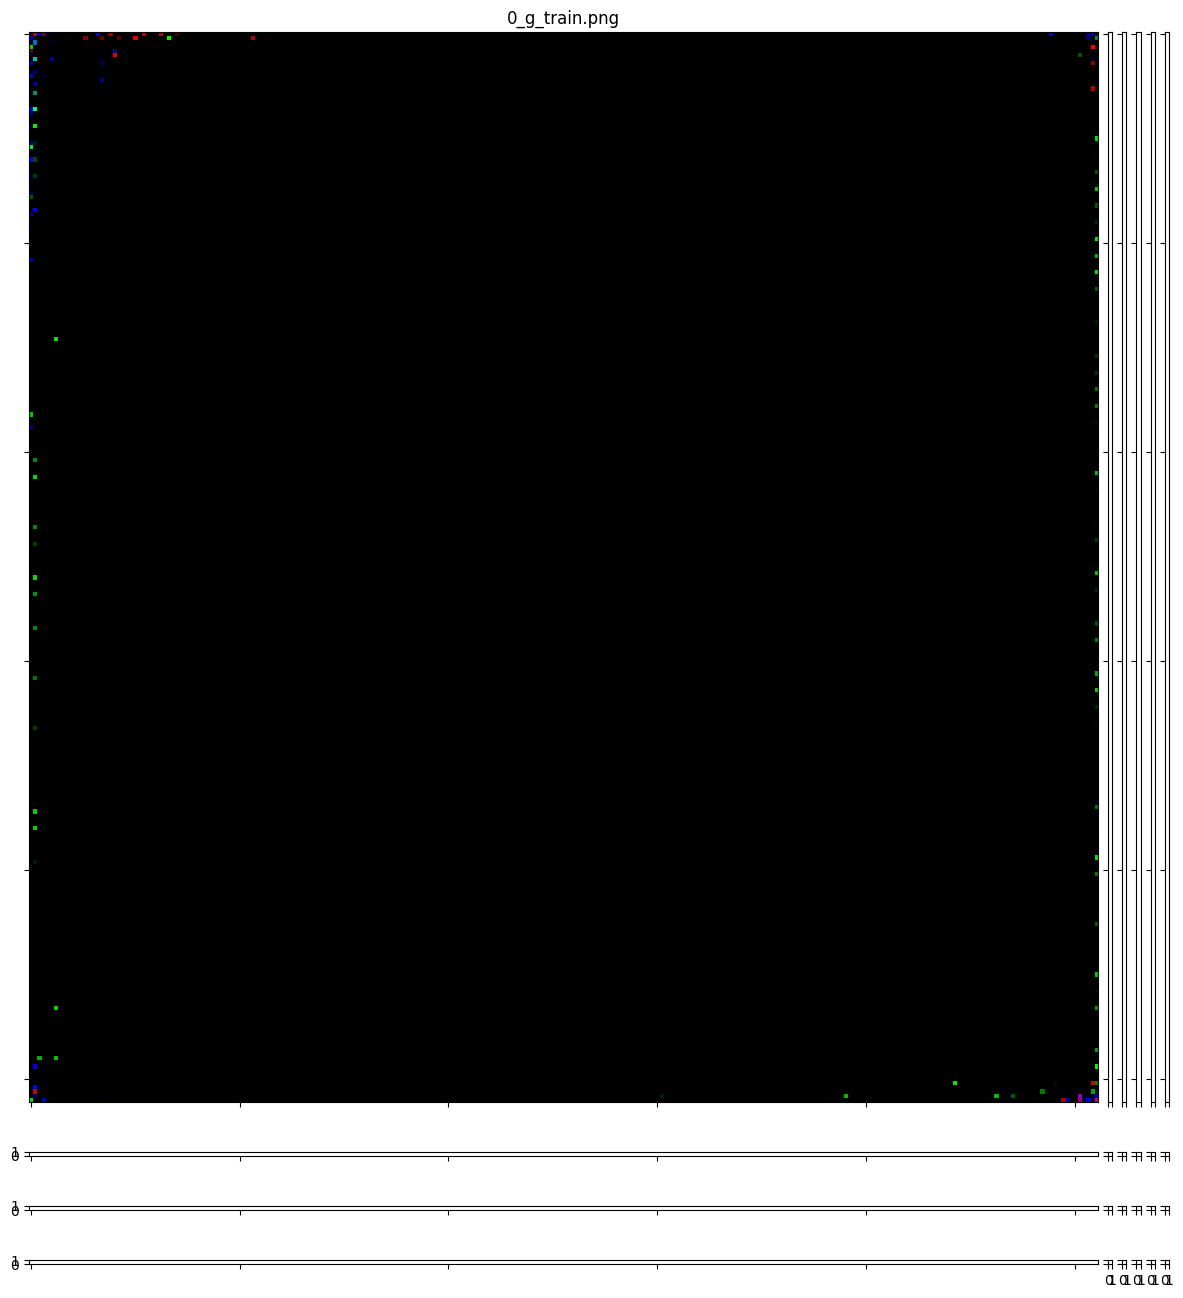

In [ ]:
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x: 'train' in x, sample_images_filepaths))
sample_images_filepaths.sort(key = lambda x: int(x.split('_')[0]))

images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

plot_images(images, titles, figsize=(20., 16.), rows=4, cols=6)

## References

> https://learnopencv.com/super-resolution-in-opencv/<br>
> https://www.kaggle.com/code/akhileshdkapse/sr-super-resolution-gan-keras
